# <font color=#cd0000> Propósito principal </font>
- La idea de este librillo es preparar el entorno para realizar pruebas para HeartBeat a ser clasificado por una mezcla de las codificaciones simbólica, tendencia y aceleración aplicadas a SMTS

## <font color=#cd0000> Leyenda </font>
- Los apartados titulados con el código de colores HEX: `#cd0000` serán apartados que tendrán todos los librillos, en concreto, aquellos especificados en el apartado `Síntesis de los criterios usados` del trabajo.
- Los apartados titulados con el código de colores HEX: `#2451ff` serán apartados de conclusiones propias de este librillo resultado de aplicar un estudio personalizado para cada planteamiento.

# <font color=#cd0000> Prerrequisitos </font>
## <font color=#cd0000> Entorno de ejecución </font>
- Cambiamos el directorio raíz del librillo para acceder cómodamente a las funciones de utilidad.

In [1]:
import os

os.chdir('../../../../')
os.listdir()


['.git',
 '.gitignore',
 '.gitmodules',
 'data',
 'HeartBeat_tmp_test_data.pkl',
 'HeartBeat_tmp_train_data.pkl',
 'pkl',
 'Pruebas',
 'README.md',
 'smts_implementation',
 'utils']

## <font color=#cd0000> Constantes y variables predefinidas </font>

In [2]:
HEARTBEAT_PATH = "data/heartbeat"

DATA_TO_SAVE = "HeartBeat"

PKL_DIR = "pkl/SMTS/HeartBeat/"
PKL_NAME = "heartbeat_SMTS_codifSimb_trend_acc.pkl"

SEED = 1


# <font color=#cd0000> Carga del Dataset </font>

In [3]:
from utils.load_data import import_heartbeat_dataset

train, test = import_heartbeat_dataset(HEARTBEAT_PATH)


In [4]:
import pickle

pickle.dump(train, open(DATA_TO_SAVE + "_tmp_train_data.pkl", 'wb'))
pickle.dump(test, open(DATA_TO_SAVE + "_tmp_test_data.pkl", 'wb'))


In [5]:
import pickle

train = pickle.load(open(DATA_TO_SAVE + "_tmp_train_data.pkl", 'rb'))
test = pickle.load(open(DATA_TO_SAVE + "_tmp_test_data.pkl", 'rb'))


In [6]:
train.reset_changes()
test.reset_changes()


# <font color=#cd0000> Preprocesamiento </font>

## <font color=#cd0000> Eliminación de datos inválidos y valores atípicos </font>
- Como ya anticipamos en el análisis en profundidad de este conjunto de datos eliminaremos todos los atributos dado su alto grado de correlación salvo los atributos: `signal_1`, `signal_10`, `signal_20`, `signal_30`, `signal_40`, `signal_50` y `signal_60`
- Eliminaremos aquellos valores fuera de los percentiles 5 y 95.

### <font color=#2451ff> Eliminación de atributos altamente correlacionados </font>

In [7]:
columns_to_remove = train.get_derived_data_columns()['attrs']
column_to_study = ['signal_1', 'signal_10', 'signal_20',
                   'signal_30', 'signal_40', 'signal_50', 'signal_60']

for col in columns_to_remove:
    if col in column_to_study:
        columns_to_remove.remove(col)

train.drop_derived_data_columns(columns_to_remove)
test.drop_derived_data_columns(columns_to_remove)


,id,TimeStamp,signal_1,signal_10,signal_20,signal_30,signal_40,signal_50,signal_60,class
0,0,0,0.004578,0.009483,0.003414,0.009437,0.008221,0.030211,1.000400,normal
1,0,1,0.011682,0.013566,0.004089,0.012686,0.012927,0.070100,0.673670,normal
2,0,2,0.017709,0.019086,0.011413,0.030151,0.039722,0.100600,0.904520,normal
3,0,3,0.016318,0.017490,0.016408,0.044615,0.059496,0.091279,1.322500,normal
4,0,4,0.011723,0.008481,0.008594,0.025718,0.030744,0.024211,1.622600,normal
...,...,...,...,...,...,...,...,...,...,...
83020,204,400,0.007057,0.001993,0.005595,0.003932,0.002723,0.002055,0.353420,abnormal
83021,204,401,0.012607,0.002142,0.004760,0.000763,0.002429,0.001636,0.349890,abnormal
83022,204,402,0.011410,0.004370,0.000505,0.000902,0.002300,0.001022,0.264820,abnormal
83023,204,403,0.008735,0.003033,0.001830,0.001835,0.004181,0.002472,0.130270,abnormal


### <font color=#2451ff> Eliminación de outliers </font>
- El grado de outliers mínimo en, al menos, una dimensión para eliminar una serie temporal será del 80% (si más del 80% de los datos son anómalos descartamos la serie).
  - A pesar de que esto pueda parecer muy grande debemos comprender que, la probabilidad con la que aparezca ruido en una de las dimensiones de una serie temporal multivariada, es muy alta (tenemos varias series temporales con ruido cada una).

In [8]:
train.remove_outliers(
    headers=train.get_derived_data_columns()['attrs'],
    outliers_limit=.8
)

test.remove_outliers(
    headers=test.get_derived_data_columns()['attrs'],
    outliers_limit=.8
)


In [9]:
import pandas as pd

# Remaining series
print("Train: Previous number of series: {}".format(
    len(pd.unique(train.original_data['id']))))
print("Train: Actual number of series: {}".format(
    len(pd.unique(train.derived_data['id']))))

print("Test: Previous number of series: {}".format(
    len(pd.unique(test.original_data['id']))))
print("Test: Actual number of series: {}".format(
    len(pd.unique(test.derived_data['id']))))


Train: Previous number of series: 204
Train: Actual number of series: 198
Test: Previous number of series: 205
Test: Actual number of series: 199


## <font color=#cd0000> Resoluciones a aplicar </font>
- Como concluimos en el análisis en profundidad, mantendremos la resolución original.

In [10]:
# Nothing to see here


# <font color=#cd0000> División en ventanas </font>
- Como concluimos en el análisis en profundidad no aplicaremos enventanado pues ya está preaplicado.

In [11]:
# Nothing to see here


## <font color=#cd0000> Codificación </font>

In [12]:
from utils.codifications import temporal_trend_fn

# Trend's codification (first derivative)
train.apply_codifications([temporal_trend_fn])
test.apply_codifications([temporal_trend_fn])


In [20]:
# Acceleration's codification (second derivative)
columns_to_derivate = list(filter(lambda z: 'Diff' in z, 
                               train.get_derived_data_columns()['attrs']))

train.apply_codifications([temporal_trend_fn], headers=columns_to_derivate)
test.apply_codifications([temporal_trend_fn], headers=columns_to_derivate)


# <font color=#cd0000> Preparación de los datos </font>

In [22]:
X_train = train.derived_data.drop(['TimeStamp', 'class'], axis=1)
X_test = test.derived_data.drop(['TimeStamp', 'class'], axis=1)

y_train = train.derived_data['class'].to_numpy()
y_test = test.derived_data['class'].to_numpy()


## <font color=#cd0000> Técnicas de balanceo </font>

### <font color=#cd0000> Asignación de pesos a las clases </font>

In [23]:
import numpy as np
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train)
class_weights = {'abnormal': class_weights[0], 'normal': class_weights[1]}


# <font color=#cd0000> Diseño de la topología del bosque </font>
- Número de árboles inicial recomendado
- Número de símbolos inicial recomendado
- Número de árboles del segundo RandomForest recomendado

## <font color=#cd0000> Entrenamiento </font>

In [32]:
from smts_implementation.smts import SMTS

clf = SMTS(
    j_ins=200,
    n_symbols=10,
    class_weight=class_weights,
    random_state=SEED
)
clf.fit(X_train, y_train)


## <font color=#cd0000> Clasificación </font>

In [33]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = clf.predict(X_test)
y_true = X_test.assign(class_name=y_test).groupby('id')\
    .first()['class_name'].to_numpy()

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, zero_division=0))


[[120  23]
 [ 29  27]]
              precision    recall  f1-score   support

    abnormal       0.81      0.84      0.82       143
      normal       0.54      0.48      0.51        56

    accuracy                           0.74       199
   macro avg       0.67      0.66      0.67       199
weighted avg       0.73      0.74      0.73       199



## <font color=#cd0000> Discusión de los resultados </font>
- Vamos a estudiar diferentes rangos de hiper-parámetros interesantes que podrían darnos alguna pista sobre el rango en el que buscar el mejor clasificador de este tipo:
  - Para un `j_ins` pequeño (10) y un `n_symbols` pequeño (10) observamos un desempeño mejor que RandomForest con la codificación de la Tendencia aplicada pero algo inferior al de SMTS con solo la codificación simbólica:
    ```
    Confusion matrix:
    [[123  20]
     [ 30  26]]

    Classification report:
                      precision    recall  f1-score   support

        abnormal       0.80      0.86      0.83       143
          normal       0.57      0.46      0.51        56

        accuracy                           0.75       199
       macro avg       0.68      0.66      0.67       199
    weighted avg       0.74      0.75      0.74       199
    ```
  - Para un `j_ins` pequeño (10) y un `n_symbols` grande (200) observamos un desempeño similar al caso anterior pero con una ligera mejora, probemos ahora a incrementar el número de estimadores:
    ```
    Confusion matrix:
    [[126  17]
     [ 30  26]]

    Classification report:
                      precision    recall  f1-score   support

        abnormal       0.81      0.88      0.84       143
          normal       0.60      0.46      0.53        56

        accuracy                           0.76       199
       macro avg       0.71      0.67      0.68       199
    weighted avg       0.75      0.76      0.75       199
    ```
  - Para un `j_ins` grande (200) y un `n_symbols` grande (200) observamos un peor desempeño en la generalización de la clase minoritaria, pero es curioso destacar que la clasificación de la mayoritaria normalmente se mantiene siempre intacta (no varía apenas):
    ```
    Confusion matrix:
    [[122  21]
     [ 32  24]]

    Classification report:
                      precision    recall  f1-score   support

        abnormal       0.79      0.85      0.82       143
          normal       0.53      0.43      0.48        56

        accuracy                           0.73       199
       macro avg       0.66      0.64      0.65       199
    weighted avg       0.72      0.73      0.72       199
    ```
  - Para un `j_ins` intermedio (100) y un `n_symbols` intermedio (100) observamos una ligera mejora con respecto al caso anterior por disminuir el número de símbolos:
    ```
    Confusion matrix:
    [[123  20]
     [ 30  26]]

    Classification report:
                      precision    recall  f1-score   support

        abnormal       0.80      0.86      0.83       143
          normal       0.57      0.46      0.51        56

        accuracy                           0.75       199
       macro avg       0.68      0.66      0.67       199
    weighted avg       0.74      0.75      0.74       199
    ```
  - Para un `j_ins` grande (200) y un `n_symbols` pequeño (10) observamos que los resultados no cambian significativamente:
    ```
    Confusion matrix:
    [[120  23]
     [ 29  27]]

    Classification report:
                      precision    recall  f1-score   support

        abnormal       0.81      0.84      0.82       143
          normal       0.54      0.48      0.51        56

        accuracy                           0.74       199
       macro avg       0.67      0.66      0.67       199
    weighted avg       0.73      0.74      0.73       199
    ```

## <font color=#cd0000> Conclusiones </font>
- Como podemos observar la influencia de añadir la tendencia y la aceleración no parece obtener resultados mucho mejores que con, únicamente, utilizar la codificación simbólica en este caso.
  - Quizás en la búsqueda de hiper-parámetros aleatoria nos llevemos alguna sorpresa.
- Parece que, como en otros estudios, sería más interesante profundizar en los rangos:
  - `j_ins`: [10, 100]
  - `n_symbols`: [10, 100]

# <font color=#cd0000> Randomized Search </font>
- Búsqueda de hiper-parámetros aleatoria con SMTS maximizando ``macro avg f1-score``

## <font color=#cd0000> Rangos de búsqueda </font>
- Como vimos anteriormente los rangos de búsqueda aleatoria de los mejores hiper-parámetros serán los siguientes

In [34]:
J_INS_RANGE = range(10, 100)
N_SYMBOLS_RANGE = range(10, 100)

In [35]:
import random
import pickle
import utils.constants as cs
from smts_implementation.smts import SMTS
from utils.classifier_utils import (windowed_cross_val,
                                    compute_classification_reports_means)
from utils.plot_utils import pretty_print_classification_report_dict


def smts_randomized_search_cv(
        windowed_series,
        relation_with_series,
        prefix,
        class_weights,
        cv=5):
    global PKL_DIR
    all_clf_used = {}

    n_samples = 5
    j_ins_list = random.sample(list(J_INS_RANGE), n_samples)
    n_symbols_list = random.sample(list(N_SYMBOLS_RANGE), n_samples)

    best_hyp_params = None
    best_score = 0
    for j_ins in j_ins_list:
        for n_symbols in n_symbols_list:
            clf = SMTS(
                j_ins=j_ins,
                n_symbols=n_symbols,
                class_weight=class_weights,
                random_state=SEED
            )

            reports = windowed_cross_val(
                clf,
                windowed_series,
                relation_with_series,
                estimator_type=cs.ESTIMATOR_SMTS,
                cv=cv,
                drop_columns=['class'],
                seed=SEED
            )
            mean_report = compute_classification_reports_means(reports)
            all_clf_used[(j_ins, n_symbols)] = mean_report

            if mean_report['macro avg']['f1-score'][0] >= best_score:
                best_score = mean_report['macro avg']['f1-score'][0]
                best_hyp_params = (j_ins, n_symbols)
                best_report = mean_report

            print("\t\t--------------ACTUAL BEST: J_ins={}; N_symbols={}--------------"
                  .format(best_hyp_params[0], best_hyp_params[1]))
            pretty_print_classification_report_dict(best_report)
            print("\t\t--------------ITERATION: J_ins={}; N_symbols={}--------------"
                  .format(j_ins, n_symbols))
            pretty_print_classification_report_dict(mean_report)

    with open(PKL_DIR + prefix, 'wb') as file:
        pickle.dump(all_clf_used, file)

    return best_hyp_params, best_report


In [36]:
smts_randomized_search_cv(
    train.derived_data,
    train.derived_data_windows_per_serie,
    PKL_NAME,
    class_weights,
    cv=5
)


		--------------ACTUAL BEST: J_ins=32; N_symbols=74--------------
Accuracy: 0.7308681412725058 +/- 0.06813840474253433
abnormal:
	precision: 0.7799768183135323 +/- 0.07471513200919842
	recall: 0.8628531126141998 +/- 0.07227736084914813
	f1-score: 0.816983573090253 +/- 0.05933160230586811
	support: 28.2 +/- 2.7856776554368237
normal:
	precision: 0.58 +/- 0.1528979325490629
	recall: 0.4144988344988345 +/- 0.057628563121813595
	f1-score: 0.46939014202172097 +/- 0.04395683547639411
	support: 11.4 +/- 2.4166091947189146
macro avg:
	precision: 0.6799884091567663 +/- 0.08282539287490809
	recall: 0.6386759735565171 +/- 0.041938046337925784
	f1-score: 0.6431868575559869 +/- 0.04997125283220609
	support: 39.6 +/- 1.0198039027185568
weighted avg:
	precision: 0.7293244778896157 +/- 0.07592637512223889
	recall: 0.7308681412725058 +/- 0.06813840474253433
	f1-score: 0.7185959863413559 +/- 0.06942033565471746
	support: 39.6 +/- 1.0198039027185568
		--------------ITERATION: J_ins=32; N_symbols=74------

((31, 74),
 {'accuracy': (0.7721839307461901, 0.04167275827365941),
  'abnormal': {'precision': (0.8128174161767043, 0.06268034626665762),
   'recall': (0.88916995419341, 0.05273784225931555),
   'f1-score': (0.8463003663003663, 0.031074363531901565),
   'support': (28.2, 2.7856776554368237)},
  'normal': {'precision': (0.6533333333333334, 0.1573546752631154),
   'recall': (0.5011655011655012, 0.10628644722278766),
   'f1-score': (0.5508187134502924, 0.086960539084621),
   'support': (11.4, 2.4166091947189146)},
  'macro avg': {'precision': (0.7330753747550188, 0.06741775232189721),
   'recall': (0.6951677276794557, 0.053972314415201506),
   'f1-score': (0.6985595398753294, 0.0546330362659465),
   'support': (39.6, 1.0198039027185568)},
  'weighted avg': {'precision': (0.7782218500851813, 0.04045108390100533),
   'recall': (0.7721839307461901, 0.04167275827365941),
   'f1-score': (0.7633207889433821, 0.04506204811913757),
   'support': (39.6, 1.0198039027185568)}})

# <font color=#cd0000> Randomized Search con múltiples ejecuciones en lugar de Validación Cruzada </font>
- No llevaremos a cabo esta aproximación ya que tenemos datos suficientes como para ejecutar validación cruzada.

In [ ]:
# Nothing to see here

# <font color=#cd0000> Análisis de resultados </font>
- Según la búsqueda aleatoria de hiper-parámetros, la mejor combinación, es la de ``j_ins`` = 31 y ``n_symbols`` = 74:
    ```
    Accuracy: 0.7721839307461901 +/- 0.04167275827365941
    abnormal:
        precision: 0.8128174161767043 +/- 0.06268034626665762
        recall: 0.88916995419341 +/- 0.05273784225931555
        f1-score: 0.8463003663003663 +/- 0.031074363531901565
        support: 28.2 +/- 2.7856776554368237
    normal:
        precision: 0.6533333333333334 +/- 0.1573546752631154
        recall: 0.5011655011655012 +/- 0.10628644722278766
        f1-score: 0.5508187134502924 +/- 0.086960539084621
        support: 11.4 +/- 2.4166091947189146
    macro avg:
        precision: 0.7330753747550188 +/- 0.06741775232189721
        recall: 0.6951677276794557 +/- 0.053972314415201506
        f1-score: 0.6985595398753294 +/- 0.0546330362659465
        support: 39.6 +/- 1.0198039027185568
    weighted avg:
        precision: 0.7782218500851813 +/- 0.04045108390100533
        recall: 0.7721839307461901 +/- 0.04167275827365941
        f1-score: 0.7633207889433821 +/- 0.04506204811913757
        support: 39.6 +/- 1.0198039027185568
    ```
- Ahora vamos a visualizar la evolución de los resultados (25 resultados) para observar cómo avanza nuestra métrica objetivo -> Macro Average F1-Score.

In [3]:
import pickle

all_reports = pickle.load(open(PKL_DIR + PKL_NAME, 'rb'))


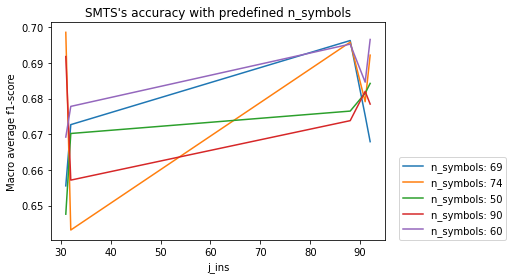

In [38]:
from utils.plot_utils import plot_score

macro_avg_f1_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['macro avg']['f1-score'][0],
                   'std': all_reports[z]['macro avg']['f1-score'][1]}),
    all_reports
))

plot_score(
    [macro_avg_f1_scores],
    ('j_ins', 'n_symbols'),
    'SMTS',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Macro Average F1-Score'
)


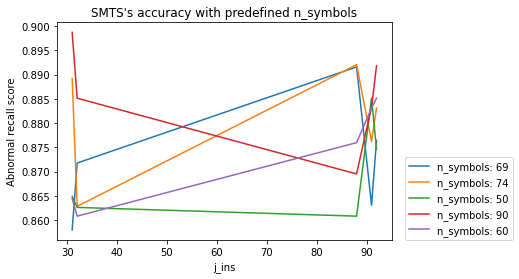

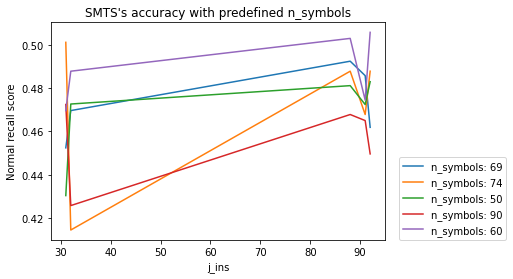

In [39]:
abnormal_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['abnormal']['recall'][0],
                   'std': all_reports[z]['abnormal']['recall'][1]}),
    all_reports
))

normal_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['normal']['recall'][0],
                   'std': all_reports[z]['normal']['recall'][1]}),
    all_reports
))

plot_score(
    [abnormal_recall_scores],
    ('j_ins', 'n_symbols'),
    'SMTS',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Abnormal recall score'
)

plot_score(
    [normal_recall_scores],
    ('j_ins', 'n_symbols'),
    'SMTS',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Normal recall score'
)


# <font color=#cd0000> Evaluación sobre el conjunto de validación </font>
- Vamos a llevar a cabo la evaluación final sobre el conjunto de validación (esto es lo que irá al apartado de ``Pruebas y Resultados`` de la memoria).

## <font color=#cd0000> Entrenamiento </font>

In [40]:
from smts_implementation.smts import SMTS

clf = SMTS(
    j_ins=31,
    n_symbols=74,
    class_weight=class_weights,
    random_state=SEED
)
clf.fit(X_train, y_train)


## <font color=#cd0000> Clasificación </font>

In [41]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = clf.predict(X_test)
y_true = X_test.assign(class_name=y_test).groupby('id')\
    .first()['class_name'].to_numpy()

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, zero_division=0))


[[124  19]
 [ 30  26]]
              precision    recall  f1-score   support

    abnormal       0.81      0.87      0.84       143
      normal       0.58      0.46      0.51        56

    accuracy                           0.75       199
   macro avg       0.69      0.67      0.67       199
weighted avg       0.74      0.75      0.74       199



# <font color=#cd0000> Conclusiones </font>
- No observamos una diferencia significativa con el mejor clasificador SMTS con SOLO codificación simbólica aunque, el entrenamiento, es algo más rápido dado el menor número de estimadores.
  - También sigue siendo apreciable la mala clasificación de la clase minoritaria, pero tener en cuenta el orden de las secuencias de nuestros datos sigue siendo mejor que no tenerla en cuenta como ocurre con el clasificador RandomForest.